In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv("../AAPL_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[23:]
df

,Close,High,Low,Open,Volume
Date,,,,,
2014-01-06,16.929031,17.018355,16.607525,16.727351,412610800
2014-01-07,16.807955,16.992205,16.741973,16.941163,317209200
2014-01-08,16.914400,16.979759,16.765941,16.769674,258529600
2014-01-09,16.698412,17.020229,16.661997,17.018361,279148800
2014-01-10,16.586985,16.831616,16.530028,16.801425,304976000
...,...,...,...,...,...
2023-12-22,192.444580,194.243775,191.818335,194.015137,37122800
2023-12-26,191.897888,192.732871,191.679200,192.454544,28919300
2023-12-27,191.997253,192.345171,189.949550,191.341204,48087700


In [3]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(data_trend, train_ratio, n_past, predict_day):
    scaler = MinMaxScaler()  
    print(data_trend.shape)
    data_trend = scaler.fit_transform(data_trend)
    
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data = df[[c for c in df.columns if c not in ['Date','Volume']]].values
train_ratio = 0.9
test_val_ratio = 0.9
n_past = 40     #移動視窗大小
predict_day = 10 #要預測後面幾天
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = preprocess(data, train_ratio, n_past, predict_day)
batch_size = 32

print(Y_train.shape)
train_set = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

val_set = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
X_train.shape[2]

(2514, 4)
torch.Size([1991, 10, 4])


4

In [4]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # 建立一個位置編碼矩陣
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶數位置
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇數位置
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x 的形狀為 (seq_length, batch_size, d_model)
        x = x + self.pe[:x.size(0)]
        return x

In [5]:
class TransformerTimeSeriesAutoregressive(nn.Module):
    def __init__(self, feature_size, num_layers=2, nhead=4, hidden_dim=128, lstm_hidden_dim=128, dropout=0.3):
        super(TransformerTimeSeriesAutoregressive, self).__init__()
        self.model_type = 'Autoregressive Transformer with LSTM Decoder and Teacher Forcing'

        self.input_linear = nn.Linear(feature_size, hidden_dim)
        self.pos_encoder = PositionalEncoding(d_model=hidden_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        # Linear projection for h_0 and c_0
        self.h0_projection = nn.Linear(hidden_dim, lstm_hidden_dim)
        self.c0_projection = nn.Linear(hidden_dim, lstm_hidden_dim)

        self.lstm_decoder = nn.LSTM(input_size=hidden_dim, hidden_size=lstm_hidden_dim, num_layers=1, batch_first=False)
        self.output_linear = nn.Linear(lstm_hidden_dim, feature_size)

        self.residual_projection = nn.Linear(feature_size, hidden_dim) if feature_size != hidden_dim else None
        self.hidden_dim = hidden_dim
        self.lstm_hidden_dim = lstm_hidden_dim

    def forward(self, src, target=None, teacher_forcing_ratio=0.5):
        batch_size, seq_length, feature_size = src.size()
        pred_length = target.size(1) if target is not None else 10

        if self.residual_projection:
            residual_src = self.residual_projection(src)
        else:
            residual_src = src
        
        residual_src = residual_src.permute(1, 0, 2)
        src = src.permute(1, 0, 2)
        src = self.input_linear(src)
        src = self.pos_encoder(src)

        transformer_output = self.transformer_encoder(src)
        transformer_output = transformer_output + residual_src

        # Use the last timestep's output to initialize h_0 and c_0
        last_step_output = transformer_output[-1]  # (batch_size, hidden_dim)
        h_0 = self.h0_projection(last_step_output).unsqueeze(0)  # (1, batch_size, lstm_hidden_dim)
        c_0 = self.c0_projection(last_step_output).unsqueeze(0)  # (1, batch_size, lstm_hidden_dim)

        # Start autoregressive decoding
        decoder_input = transformer_output[-1, :, :].unsqueeze(0)  # (1, batch_size, hidden_dim)
        outputs = []

        for t in range(pred_length):
            lstm_output, (h_0, c_0) = self.lstm_decoder(decoder_input, (h_0, c_0))
            lstm_output = lstm_output + decoder_input
            output = self.output_linear(lstm_output.squeeze(0))
            outputs.append(output.unsqueeze(1))

            if target is not None and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input = self.input_linear(target[:, t, :]).unsqueeze(0)
            else:
                decoder_input = self.input_linear(output).unsqueeze(0)

        outputs = torch.cat(outputs, dim=1)
        return outputs


In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# 檢查是否有可用的GPU
if torch.cuda.is_available():
    print("GPU")
    device = torch.device("cuda")  # 使用GPU
else:
    print("CPU")
    device = torch.device("cpu")  # 使用CPU
# 設置訓練參數
num_epochs = 100
learning_rate = 1e-4

feature_size = 4  # 輸入特徵數
num_layers = 2
nhead = 4
hidden_dim = 128

model = TransformerTimeSeriesAutoregressive(feature_size=feature_size, num_layers=num_layers, nhead=nhead, hidden_dim=hidden_dim).to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

GPU


In [7]:
# 記錄每個 epoch 的損失值
train_losses = []
val_losses = []
min_loss = 100
min_val_loss = float('inf')
best_model_path = "trans_lstm_10.pth"

# 訓練模型
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch= x_batch.to(device)
        # print(x_batch.shape)
        y_batch= y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch, y_batch, teacher_forcing_ratio=0.5).squeeze(-1)
        # print(outputs.shape)
        # print(y_batch.shape)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # 驗證模型
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch= x_batch.to(device)
            y_batch= y_batch.to(device)
            outputs = model(x_batch, y_batch, teacher_forcing_ratio=0.0).squeeze(-1)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if val_loss < min_val_loss and epoch>50:
        min_val_loss = val_loss
        torch.save(model, best_model_path)  
        print(f"Model saved with val_loss: {val_loss:.4f}")
    
    # 打印每個epoch的訓練和驗證損失
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/100], Train Loss: 0.0250, Val Loss: 0.0758
Epoch [2/100], Train Loss: 0.0735, Val Loss: 0.1817
Epoch [3/100], Train Loss: 0.0241, Val Loss: 0.0267
Epoch [4/100], Train Loss: 0.0078, Val Loss: 0.0071
Epoch [5/100], Train Loss: 0.0031, Val Loss: 0.0088
Epoch [6/100], Train Loss: 0.0030, Val Loss: 0.0083
Epoch [7/100], Train Loss: 0.0027, Val Loss: 0.0028
Epoch [8/100], Train Loss: 0.0025, Val Loss: 0.0030
Epoch [9/100], Train Loss: 0.0027, Val Loss: 0.0025
Epoch [10/100], Train Loss: 0.0020, Val Loss: 0.0019
Epoch [11/100], Train Loss: 0.0017, Val Loss: 0.0025
Epoch [12/100], Train Loss: 0.0014, Val Loss: 0.0014
Epoch [13/100], Train Loss: 0.0014, Val Loss: 0.0015
Epoch [14/100], Train Loss: 0.0016, Val Loss: 0.0024
Epoch [15/100], Train Loss: 0.0011, Val Loss: 0.0027
Epoch [16/100], Train Loss: 0.0011, Val Loss: 0.0017
Epoch [17/100], Train Loss: 0.0010, Val Loss: 0.0050
Epoch [18/100], Train Loss: 0.0009, Val Loss: 0.0013
Epoch [19/100], Train Loss: 0.0010, Val Loss: 0.0012
Ep

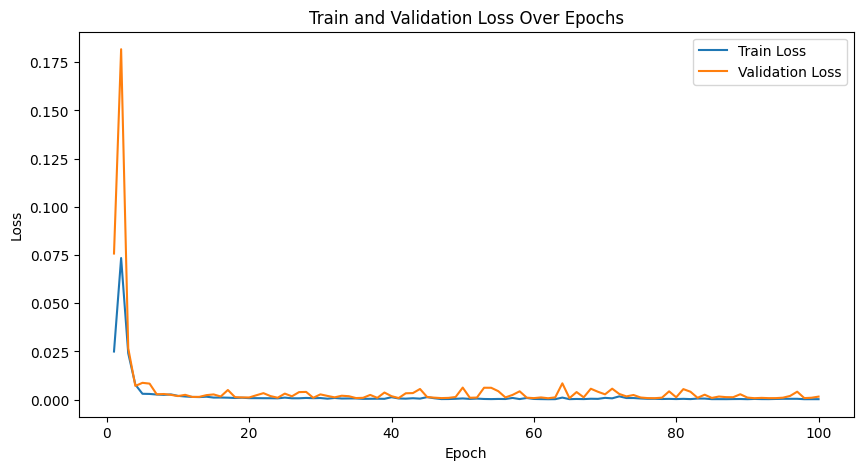

In [8]:
import matplotlib.pyplot as plt
# 繪製損失走勢圖
plt.figure(figsize=(10, 5))
plt.plot(range(1, 100+1), train_losses, label='Train Loss')
plt.plot(range(1, 100+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.show()

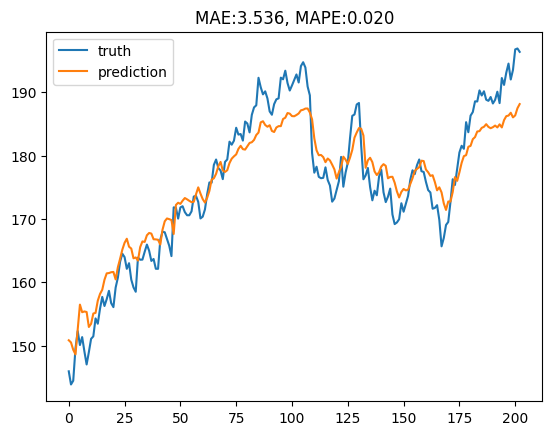

In [7]:
import matplotlib.pyplot as plt
close_price_true = []
close_price_pred = []
model = torch.load('trans_lstm_10.pth')
model.to(device)

dim = 0
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device), y.to(device), teacher_forcing_ratio=0).squeeze(-1)
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[0,dim])
    close_price_true.append(scaler.inverse_transform(y)[0,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[0,dim])

mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
plt.plot(close_price_true)
plt.plot(close_price_pred)
plt.title('MAE:{:.3f}, MAPE:{:.3f}'.format(mae, mape))
plt.legend(['truth', 'prediction'])

In [8]:
close_price_true = []
close_price_pred = []

dim = 0
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device), y.to(device), teacher_forcing_ratio=0)
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[:,dim])
    close_price_true.append(scaler.inverse_transform(y)[:,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[:,dim])

print(np.array(close_price_true).shape)
print(np.array(close_price_pred).shape)
mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
print("mape: ", mape)
print("mae: ", mae)

(203, 10)
(203, 10)
mape:  0.022666805783715126
mae:  3.992445051932695


In [9]:
import json

close_price_true = [item.tolist() for item in close_price_true]
with open('../test_price10.json', 'w') as f:
    json.dump(close_price_true, f)